## Face_it Project

### VGG16 MODEL using the fer_merged_clean dataset!

New dataset: *merged_disgust_clean.csv*

- Here we trained a deep learning model for facial emotion recognition using VGG16 with transfer learning.
- The model was fine-tuned on a merged dataset of facial expressions, including the disgust class from an extended source.
- After preprocessing and data augmentation, the network was trained for 25 epochs with early stopping and learning rate reduction strategies.

✅ This model achieved **65% validation accuracy**.

In [1]:
# ===================================================
# IMPORTS
# ===================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

print("✅ Libraries already imported!")

2025-09-08 15:38:11.281220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757345891.473655      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757345891.529985      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Libraries already imported!


### **Load Dataset**

In [2]:
#Kaggle:
df = pd.read_csv('/kaggle/input/merged-disgust-csv/merged_disgust_clean.csv')

#Colab:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/merged_disgust_clean.csv')

print("✅ Data loaded! Dataset shape:", df.shape)

df.head(3)

✅ Data loaded! Dataset shape: (38243, 2)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...


In [3]:
emotion_dict = { 0: "Angry",
                 1: "Disgust",
                 2: "Fear",
                 3: "Happy",
                 4: "Sad",
                 5: "Surprise",
                 6: "Neutral" }


#  DataFrame with emotion code, type, and count
emotion_counts = df['emotion'].value_counts().sort_index()
emotion_label = [emotion_dict[i] for i in emotion_counts.index]

summary = pd.DataFrame({ #'Emotion ID': emotion_counts.index,
                         'Emotion Label': emotion_label,
                        'Count': emotion_counts.values   })
summary

,Emotion Label,Count
0,Angry,4717
1,Disgust,4724
2,Fear,4802
3,Happy,8794
4,Sad,5912
5,Surprise,3248
6,Neutral,6046


### **Preprocessor**

In [4]:
# ===================================================
# IMAGE PROCESSING
# ===================================================

# Convert 'pixels' column into image arrays (48x48 grayscale → RGB)
img_array = df.pixels.apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48).astype('uint8'))
img_array = np.stack(img_array, axis=0)
print("- Grayscale array shape:", img_array.shape)

# Convert to RGB
img_features = np.stack([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in img_array])
print("- RGB image shape:", img_features.shape)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['emotion'])
y = to_categorical(y_encoded)
print("- Labels shape:", y_encoded.shape)

- Grayscale array shape: (38243, 48, 48)
- RGB image shape: (38243, 48, 48, 3)
- Labels shape: (38243,)


In [6]:
# ===================================================
# TRAIN / VALIDATION SPLIT
# ===================================================

X_train, X_valid, y_train, y_valid = train_test_split( img_features,
                                                       y,
                                                       test_size=0.2,
                                                       stratify=y,
                                                       random_state=42 )

In [7]:
# ===================================================
# PREPROCESS FOR VGG16
# ===================================================

X_train = preprocess_input(X_train.astype('float32'))
X_valid = preprocess_input(X_valid.astype('float32'))

num_classes = y_train.shape[1]

num_classes

7

### **Model Architecture**

In [9]:
#from tensorflow.keras.regularizers import l2

def initialize_model():

  # Load VGG16 base model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

  output =  Dense(num_classes, activation='softmax')(GlobalAveragePooling2D()(base_model.layers[-2].output))
  #output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(GlobalAveragePooling2D()(base_model.layers[-2].output))

  model = Model(inputs=base_model.input, outputs=output)

  return model

In [10]:
vgg_model = initialize_model()
vgg_model.summary()

I0000 00:00:1757346234.515423      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

### **Data Augmentation**

In [11]:
# ===================================================
# DATA AUGMENTATION
# ===================================================

es = EarlyStopping( monitor='val_loss',
                    min_delta=1e-5,
                    patience=10,
                    verbose=1,
                    restore_best_weights=True )

lr_scheduler = ReduceLROnPlateau( monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  min_lr=1e-7,
                                  verbose=1 )

callbacks = [es, lr_scheduler]

train_datagen = ImageDataGenerator( preprocessing_function=None,  # already preprocessed
                                    rotation_range=15,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    shear_range=0.15,
                                    zoom_range=0.15,
                                    horizontal_flip=True
                                  )

train_datagen.fit(X_train)

In [12]:
# ====================================
#   COMPILE MODEL
# ====================================

def compile_model(model):

    model.compile( loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-4),
                   metrics=['accuracy']  )
    
    return model

### **Fitting the Model**

In [13]:
# ===================================
#  TRAINING --> Turn on the GPU here!
# ====================================

model = initialize_model()
model = compile_model(model)

batch_size = 64 ## go 64 or higher! (and even add some Regularizaton: L1 or L2) Or maybe MaxPooling 
epochs = 50

history = model.fit( train_datagen.flow(X_train, y_train, batch_size=batch_size),
                         validation_data=(X_valid, y_valid),
                         steps_per_epoch= int(len(X_train) // batch_size),
                         epochs=epochs,
                         callbacks=callbacks )

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757346294.542165     100 service.cc:148] XLA service 0x7a917c0031e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757346294.543004     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757346295.180176     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/478 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.1263 - loss: 10.3477  

I0000 00:00:1757346300.800300     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


478/478 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.2683 - loss: 2.0539 - val_accuracy: 0.4580 - val_loss: 1.4169 - learning_rate: 1.0000e-04
Epoch 2/50
  1/478 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4531 - loss: 1.4968

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4531 - loss: 1.4968 - val_accuracy: 0.4652 - val_loss: 1.4182 - learning_rate: 1.0000e-04
Epoch 3/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.4454 - loss: 1.4613 - val_accuracy: 0.5079 - val_loss: 1.3039 - learning_rate: 1.0000e-04
Epoch 4/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6094 - loss: 1.2064 - val_accuracy: 0.5176 - val_loss: 1.2759 - learning_rate: 1.0000e-04
Epoch 5/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.5050 - loss: 1.3115 - val_accuracy: 0.5492 - val_loss: 1.2180 - learning_rate: 1.0000e-04
Epoch 6/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5156 - loss: 1.3251 - val_accuracy: 0.5446 - val_loss: 1.2318 - learning_rate: 1.0000e-04
Epoch 7/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.5486 - loss: 1.2140 - val_accuracy: 0.5748 - val_loss: 1.1608 - learning_rate: 1.0000e-04
Epoch 8/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.578

In [14]:
# ===================================================
# EVALUATION
# ===================================================
val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=0)

print(f"\n✅ Validation Accuracy: {val_acc * 100:.1f}%")


✅ Validation Accuracy: 64.9%


### **Visualizing our results**

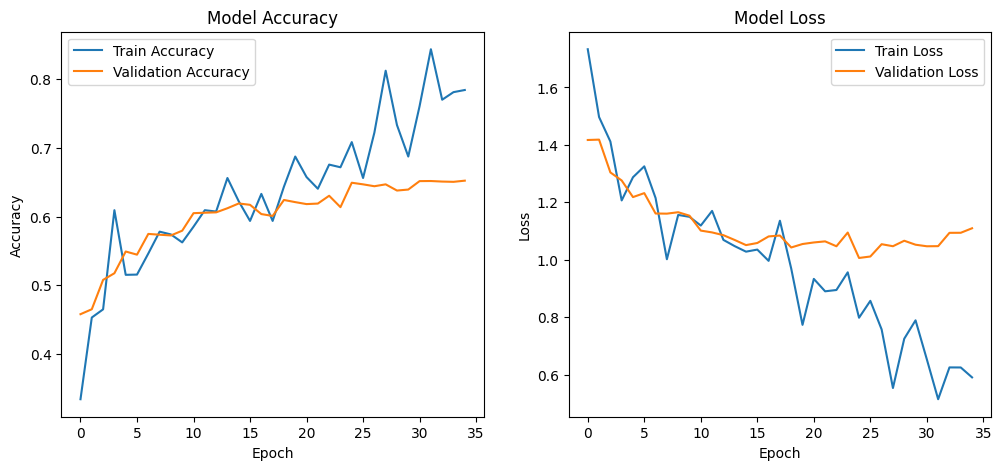

In [15]:
# ====================================
#  PLOTTING
# ====================================

plt.figure(figsize=(12,5))

# ACCURACY
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# LOSS
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


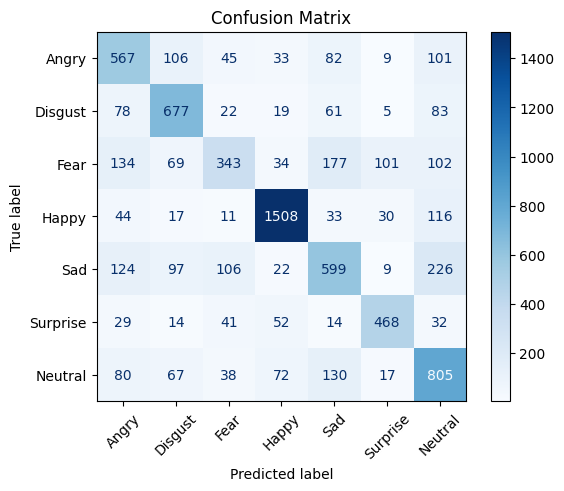

In [17]:
# ====================================
#  CONFUSION MATRIX
# ====================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set
y_pred_probs = model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display with sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_dict.values()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### Key Insights

- **Diagonal values** (correct predictions) → This model predicts Happy (1508), Neutral (805), and Disgust (677) well, i.e. these are our strongest classes.

- **Class imbalance** → 'Happy' still dominates the dataset (high numbers), which can bias the model toward being better at that class.

- Sad can be often confused with Angry (124), Disgust (97), and Neutral (226).

- Fear is confused with Angry and Sad.

- Angry is sometimes predicted as Disgust (106).

- **Weaker classes** → Fear (343 correct vs. many misclassifications) and Sad (599 correct but many confused with others) are the hardest for the model.

So basically this version of my model has good precision on strong classes (Happy, Neutral, Disgust), but still struggles to separate emotions with similar facial cues like Sad, Fear, and Angry.

---

### **Save the Model**

In [19]:
# Save full model (architecture + weights + optimizer state)

model.save("best_model_rafa.keras")

---

### **Testing if model works**

- STEP 1 - Load the Model
- STEP 2 - Load and preprocess my test image
- STEP 3 - Predict

My model was trained here on 48×48 RGB images and preprocessed with preprocess_input (VGG16 style)... i.e. here we need do the same for our NEW test image:

### **Step 1 - Load your model**

In [20]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/best_model_rafa.keras")

### **Step 2 & 3 - Function to process new image and return prediction**

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Dictionary of class labels
emotion_dict = {    0: "Angry", 
                    1: "Disgust", 
                    2: "Fear", 
                    3: "Happy", 
                    4: "Sad", 
                    5: "Surprise", 
                    6: "Neutral" }


def predict_emotion(img_path, model):
    """
    Loads an image, preprocesses it, predicts the emotion,
    and displays the image with the predicted label.
    """
    
    # Step 1: Load and preprocess image
    img = image.load_img(img_path, target_size=(48, 48), color_mode="rgb")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize
    
    # Step 2: Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = emotion_dict[predicted_class]
    
    # Step 3: Show image + prediction
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}")
    plt.show()
    
    return predicted_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


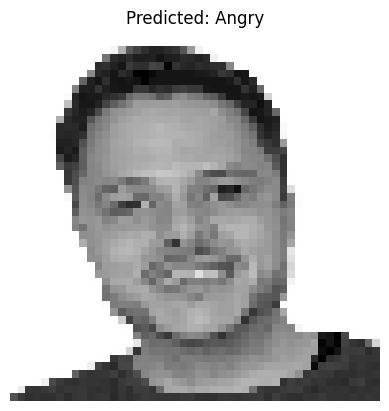

'Angry'

In [22]:
## Just change the image path below:

predict_emotion("/kaggle/input/sample-images/sample_2.png", model)

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_emotion(img_path, model):
    """
    Loads an image, detects face, preprocesses it, 
    predicts the emotion with the trained model,
    and displays the original image with prediction.
    """

    # Load image
    image = cv2.imread(img_path)
    if image is None:
        raise ValueError(f"Image not found at {img_path}")

    # Convert to grayscale for face detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(
        gray_image, scaleFactor=1.05, minNeighbors=3, minSize=(20, 20)
    )

    if len(faces) == 0:
        print("⚠️ No face detected, using full image (less accurate).")
        face_crop = cv2.resize(gray_image, (48, 48))
    else:
        # Take first detected face
        x, y, w, h = faces[0]
        face_crop = gray_image[y:y+h, x:x+w]
        face_crop = cv2.resize(face_crop, (48, 48))

    # Convert grayscale → RGB (model was trained on 3 channels)
    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_GRAY2RGB)

    # Preprocess for model
    input_face = np.expand_dims(face_rgb, axis=0) / 255.0

    # Predict emotion
    predictions = model.predict(input_face, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_emotion = emotion_dict[predicted_class]
    confidence = np.max(predictions) * 100

    # Display original image with prediction
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Emotion: {predicted_emotion}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

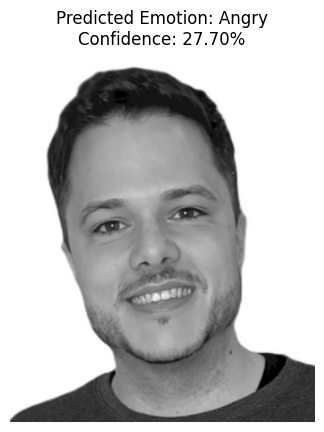

In [24]:
predict_emotion("/kaggle/input/sample-images/sample_2.png", model)

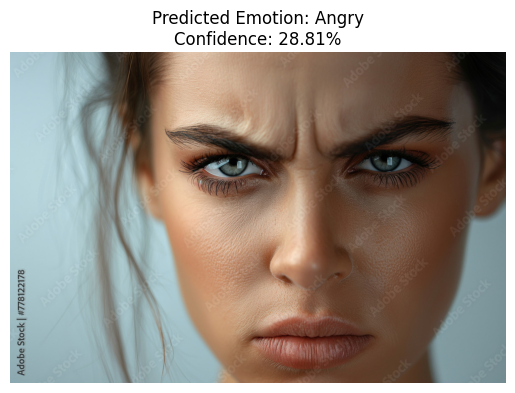

In [25]:
result = predict_emotion("/kaggle/input/sample-images/sample_3.png" , model)

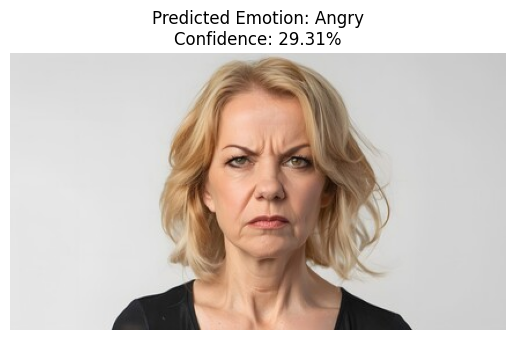

In [26]:
result = predict_emotion("/kaggle/input/sample-images/sample_4.png" , model)

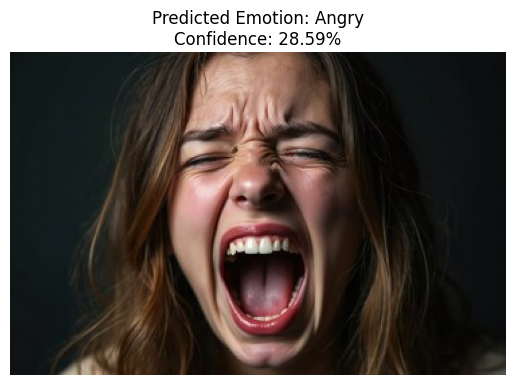

In [29]:
result = predict_emotion("/kaggle/input/sample-images/sample_6.jpg" , model)

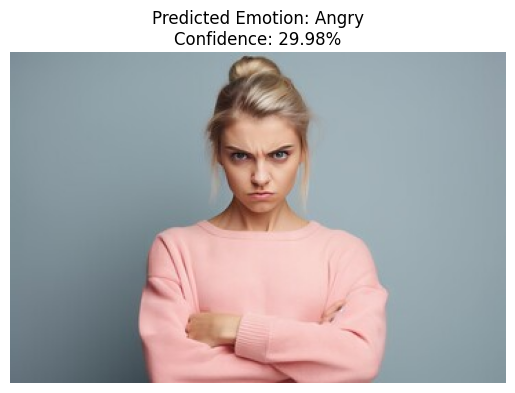

In [30]:
result = predict_emotion("/kaggle/input/sample-images/sample_7.png" , model)

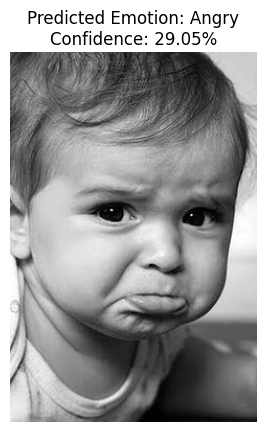

In [31]:
result = predict_emotion("/kaggle/input/sample-images/sample_8.png" , model)

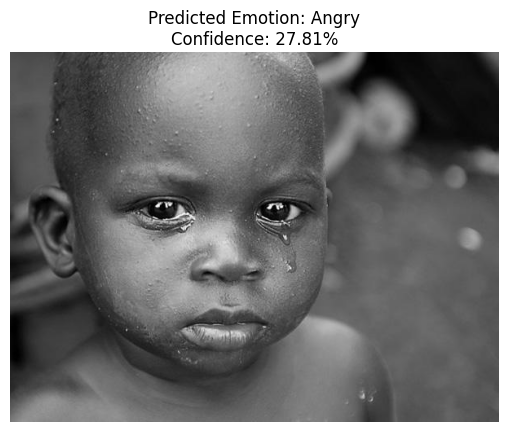

In [32]:
result = predict_emotion("/kaggle/input/sample-images/sample_9.png" , model)

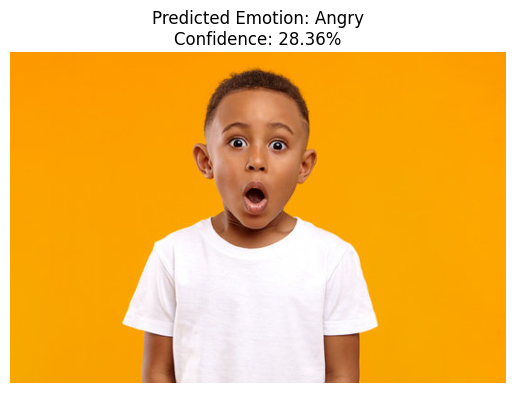

In [33]:
result = predict_emotion("/kaggle/input/sample-images/sample_10.png" , model)

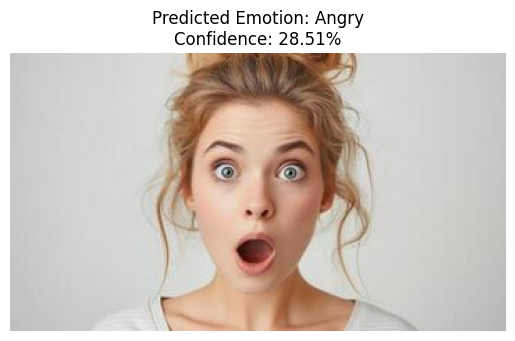

In [35]:
result = predict_emotion("/kaggle/input/sample-images/sample_11.png" , model)